# Benford's Law - Uncovering Fraud

**What is Benford's Law?**

Benford's law is an observation about the frequency distribution of leading digits in many real-life sets of numerical data. The law states that in many naturally occurring collections of numbers, the leading significant digit is likely to be small. For example, in sets that obey the law, the number 1 appears as the most significant digit about 30% of the time, while 9 appears as the most significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time. Benford's law also makes predictions about the distribution of second digits, third digits, digit combinations, and so on.

https://en.wikipedia.org/wiki/Benford%27s_law

**How is Benford's Law applied to the real world?**

Benford's law has many great applications in exploratory data analysis. To give an example, forensic accountants typically use Benford's law to screen for irregularities in financial reports. Financial datasets tend to follow Benford's law unless human intervention is involved, which can sometimes lead to fraud.

As a mini data science project I wanted to apply Benford's Law to voucher payments paid by the City of San Francisco.

**Some background information on the dataset:**

The San Francisco Controller's Office maintains a database of payments made to vendors from fiscal year 2007 forward. This data is presented on the Vendor Payments report hosted at http://openbook.sfgov.org, and is also available in this dataset in CSV format, which represents detailed data by voucher. We have removed sensitive information from this data – this is intended to show payments made to entities providing goods and services to the City and County and to protect individuals. For example, we have removed payments to employees (reimbursements, garnishments) and jury members, revenue refunds, payments for judgments and claims, witnesses, relocation and rehousing, and a variety of human services payments. New data is added on a weekly basis.

City Department spending may occur three ways: 1) from Contract to Purchase Order (i.e. a PO with an accounting Encumbrance) to Payment (i.e. an accounting Voucher), AKA On-Contract spending, 2) direct-to-Purchase Order (no contract, only a PO agreement and accounting Encumbrance) to Payment, and 3) Direct Voucher Payment (for limited one-time, non-recurring payments, e.g. a membership or a subscription). Therefore, it is helpful to use both the Supplier Contracts and Supplier Payments reports on SFOpenBook, as well as on DataSF.

Source: https://data.sfgov.org/City-Management-and-Ethics/Vendor-Payments-Vouchers-/n9pm-xkyq/data


### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

### Benford Bar Chart

First I want to plot each digit of Benford's Law to see the distribution for each digit.

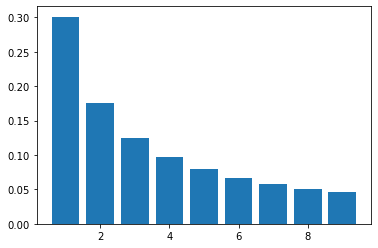

In [2]:
digits = list(range(1,10))
benford = [np.log10(1 + 1/ d) for d in digits]
plt.bar(digits, benford);

### Load the Dataset

The dataset is publicly available at the link above. I downloaded it as a CSV file. As of February 2021, there were almost 5.5 million rows of data. I decided to narrow the scope of the project to the last couple years of data, which still gave me about 1.1 million rows of voucher payments. 

In [3]:
# Import the csv file as a datafram
df = pd.read_csv('./Vendor_Payments__Vouchers_.csv', low_memory=False)

In [4]:
# Noted about 5.5 million rows
df.shape

(5486931, 26)

### EDA

In [5]:
# Looked at the first several rows of data
df.head(3)

,Fiscal Year,Related Govt Units,Organization Group Code,Organization Group,Department Code,Department,Program Code,Program,Character Code,Character,Object Code,Object,Sub-object Code,Sub-object,Fund Type Code,Fund Type,Fund Code,Fund,Fund Category Code,Fund Category,Purchase Order,Vendor,Vouchers Paid,Vouchers Pending,Vouchers Pending Retainage,Voucher
0,2007,No,5,Culture & Recreation,AAM,AAM Asian Art Museum,EEI,Asian Arts Museum,521,Non Personnel Services,528,Maint Svcs-Building&Structures,528010,Scavenger Services,1G,General Fund,1GAGF,General Fund,2.0,Annual Projects,DPAA0700000201,RECOLOGY GOLDEN GATE,3461.38,0.0,NaN,VCAA0700000101
1,2007,No,5,Culture & Recreation,AAM,AAM Asian Art Museum,EEI,Asian Arts Museum,521,Non Personnel Services,528,Maint Svcs-Building&Structures,528010,Scavenger Services,1G,General Fund,1GAGF,General Fund,2.0,Annual Projects,DPAA0700000201,RECOLOGY GOLDEN GATE,3461.38,0.0,NaN,VCAA0700000501
2,2007,No,5,Culture & Recreation,AAM,AAM Asian Art Museum,EEI,Asian Arts Museum,521,Non Personnel Services,528,Maint Svcs-Building&Structures,528010,Scavenger Services,1G,General Fund,1GAGF,General Fund,2.0,Annual Projects,DPAA0700000201,RECOLOGY GOLDEN GATE,2661.35,0.0,NaN,VCAA0700000801


In [6]:
# Reviewed the datatypes
df.dtypes

Fiscal Year                     int64
Related Govt Units             object
Organization Group Code         int64
Organization Group             object
Department Code                object
Department                     object
Program Code                   object
Program                        object
Character Code                 object
Character                      object
Object Code                    object
Object                         object
Sub-object Code                object
Sub-object                     object
Fund Type Code                 object
Fund Type                      object
Fund Code                      object
Fund                           object
Fund Category Code            float64
Fund Category                  object
Purchase Order                 object
Vendor                         object
Vouchers Paid                 float64
Vouchers Pending              float64
Vouchers Pending Retainage    float64
Voucher                        object
dtype: objec

In [7]:
# Narrowed the data to 2019 to February 2021
df = df[df['Fiscal Year'] > 2018]
df.shape

(1231653, 26)

In [8]:
# Eliminated vouchers less than $10 to eliminate
# refunds and immaterial payments
df = df[df['Vouchers Paid'] > 10].copy()
df.shape

(1126948, 26)

In [9]:
# Confirmed that vouchers are not missing values for "Vouchers Paid"
df.isna().sum()

Fiscal Year                      0
Related Govt Units               0
Organization Group Code          0
Organization Group               0
Department Code                  0
Department                       0
Program Code                  1539
Program                       1539
Character Code                   0
Character                        0
Object Code                      0
Object                           0
Sub-object Code                  0
Sub-object                       0
Fund Type Code                   0
Fund Type                        0
Fund Code                        0
Fund                            15
Fund Category Code               0
Fund Category                    0
Purchase Order                   0
Vendor                           0
Vouchers Paid                    0
Vouchers Pending                 0
Vouchers Pending Retainage       0
Voucher                          0
dtype: int64

**Duplicates**

I considered the possibility of duplicated payments in the dataset. There are potentially 125 rows that are duplicated; however I do not have information on whether these duplicate payments are errors or correct. They could be two equal payments for the same purchase order. The code below shows one instance. The MTA could have paid two equal installments to Hitachi Rail USA Inc. I decided to leave these 125 rows in dataset and assume the city has properly maintained their records. 

In [10]:
df[df['Voucher'] == '0068752801']

,Fiscal Year,Related Govt Units,Organization Group Code,Organization Group,Department Code,Department,Program Code,Program,Character Code,Character,Object Code,Object,Sub-object Code,Sub-object,Fund Type Code,Fund Type,Fund Code,Fund,Fund Category Code,Fund Category,Purchase Order,Vendor,Vouchers Paid,Vouchers Pending,Vouchers Pending Retainage,Voucher
4258237,2019,NO,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,CAP,Capital,CURR_ASSETS,Current Assets,DEP_INV_CITY_TREAS,Deposits/Invests City Treasury,EQ_CITY_TREAS_POOL,Equity in City Treasury-Pooled,ENT_FUND,Enterprise Funds,ENT_FUND~MTA_TRANSIT,Transit,0.0,Unspecified,000005179002,HITACHI RAIL USA INC,726514.49,0.0,0.0,0068752801
4258238,2019,NO,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,CAP,Capital,CURR_ASSETS,Current Assets,DEP_INV_CITY_TREAS,Deposits/Invests City Treasury,EQ_CITY_TREAS_POOL,Equity in City Treasury-Pooled,ENT_FUND,Enterprise Funds,ENT_FUND~MTA_TRANSIT,Transit,0.0,Unspecified,000005179002,HITACHI RAIL USA INC,726514.49,0.0,0.0,0068752801


In [11]:
dups = df[df.duplicated()]
print("The number of possible duplicates", dups.shape[0])
print("The percentage of duplicate rows to total rows", dups.shape[0] / df.shape[0])

The number of possible duplicates 125
The percentage of duplicate rows to total rows 0.00011091904861626268


### Feature Engineering - First_Digit category

I need to create a new column that stores the first digit of each payment.

In [12]:
def first_digit(amount):
    return int(str(amount)[0])
df['first_digit'] = df['Vouchers Paid'].map(first_digit)

### Plot Actual Percentages vs. Expected (Benford) Percentages

To start I will plot all 1.1 million payments against Benford's Law.

In [13]:
# Save the actual payment vouchers to a variable
actual_percentages = df['first_digit'].value_counts(normalize=True).sort_index()

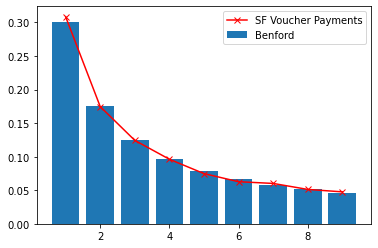

In [14]:
# Plot the actual payments (line) against Benford's Law (bars)
plt.bar(digits, benford, label = 'Benford')
plt.plot(digits, actual_percentages, color='r', marker='x', label='SF Voucher Payments')
plt.legend();

The 1.1 million payments follows Benford's Law.  

### By Department

While I don't see a significant departure from Benford's Law when analyzing all of the data, I'm curious if each department also follows Benford's Law. 

In [15]:
dept_checks = df['Department'].value_counts()
large_dept = list(dept_checks[dept_checks > 1000].index)
large_dept
# 45 departments

['DPH Public Health',
 'PUC Public Utilities Commsn',
 'MTA Municipal Transprtn Agncy',
 'ADM GSA - City Administrator',
 'AIR Airport Commission',
 'DPW GSA - Public Works',
 'HSA Human Services Agency',
 'TTX Treasurer/Tax Collector',
 'REC Recreation & Park Commsn',
 'LIB Public Library',
 'POL Police',
 'GEN General City / Unallocated',
 'CRT Superior Court',
 'MYR Mayor',
 'CAT City Attorney',
 'REG Elections',
 'HOM Homelessness Services',
 'FIR Fire Department',
 'PRT Port',
 'SHF Sheriff',
 'CHF Children;Youth & Families',
 'DT  GSA - Technology',
 'ECN Economic & Wrkfrce Dvlpmnt',
 'ART Arts Commission',
 'HSS Health Service System',
 'DAT District Attorney',
 'JUV Juvenile Probation',
 'DBI Building Inspection',
 'RET Retirement System',
 'CON Controller',
 'PDR Public Defender',
 'DEM Emergency Management',
 'ENV Environment',
 'ADP Adult Probation',
 'CPC City Planning',
 'CII Community Invest/Infrastr',
 'WAR War Memorial',
 'HRD Human Resources',
 'CSS Child Support Servi

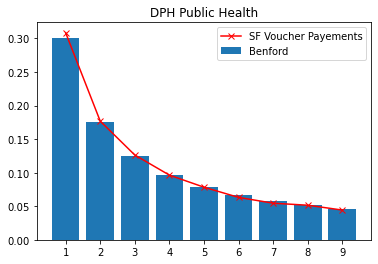

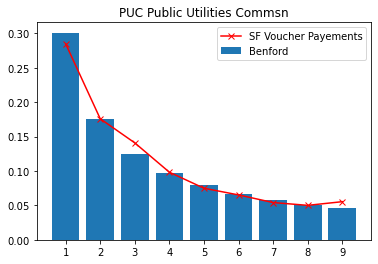

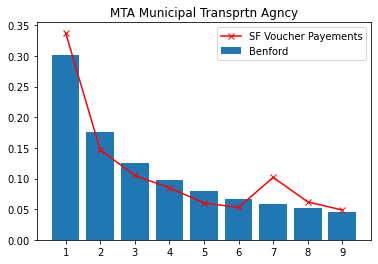

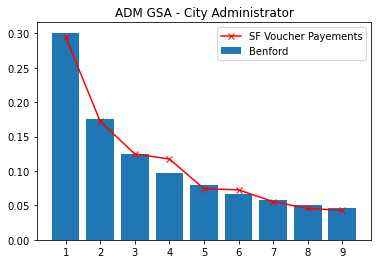

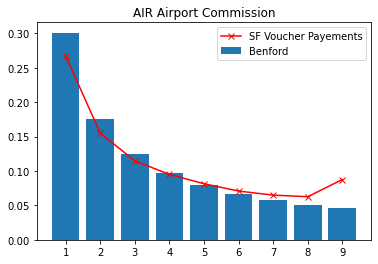

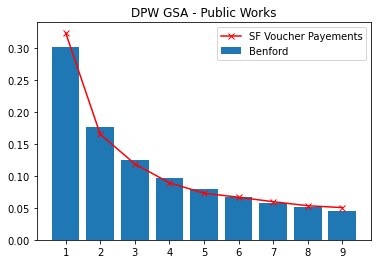

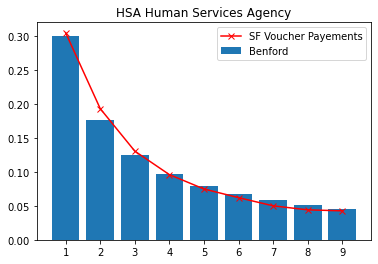

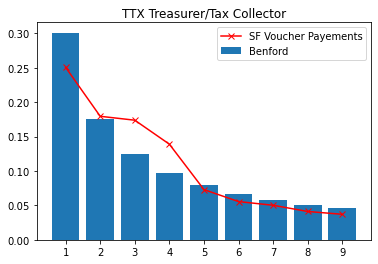

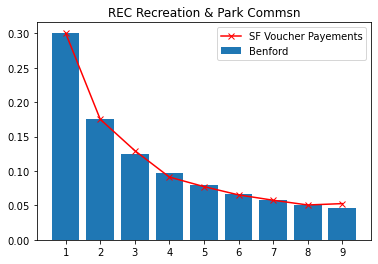

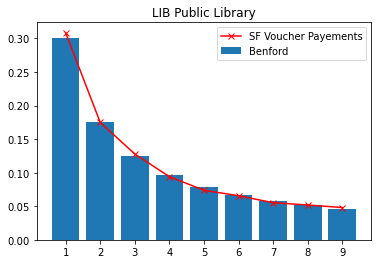

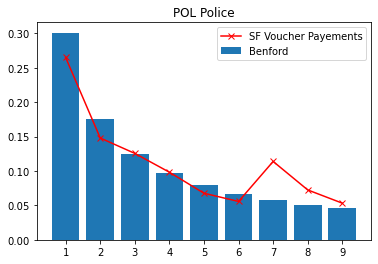

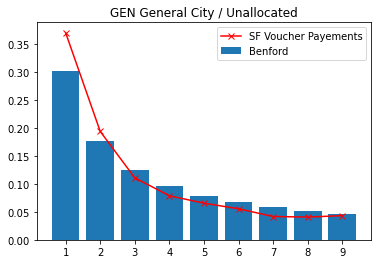

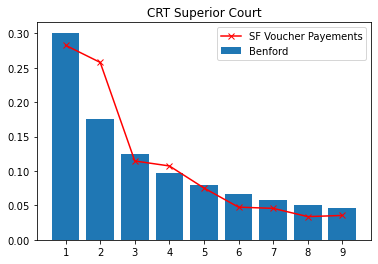

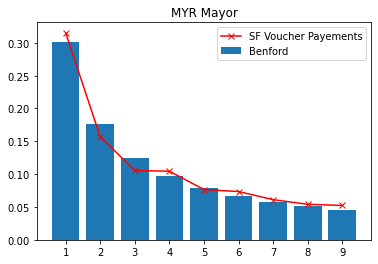

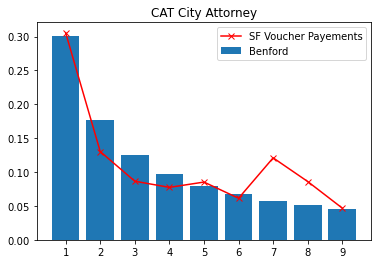

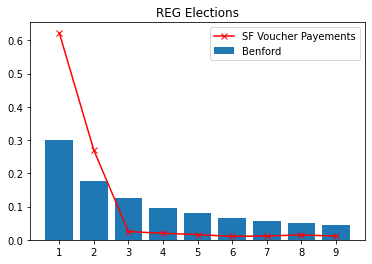

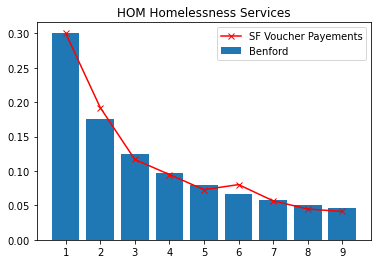

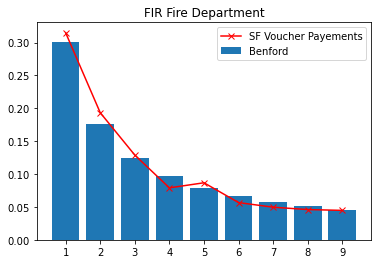

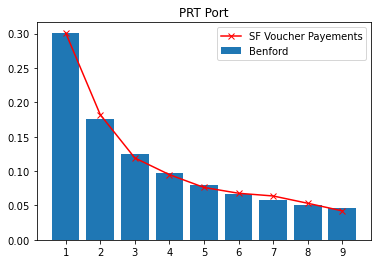

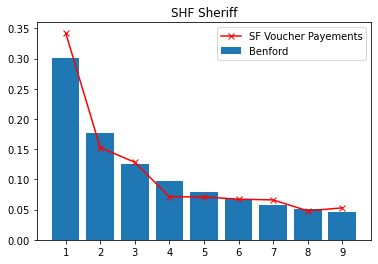

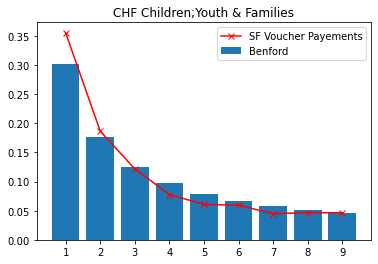

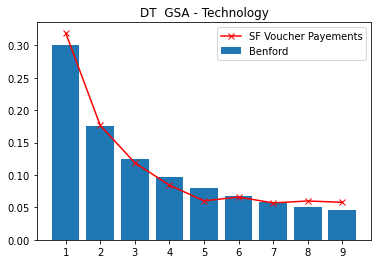

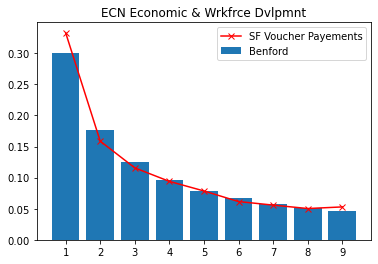

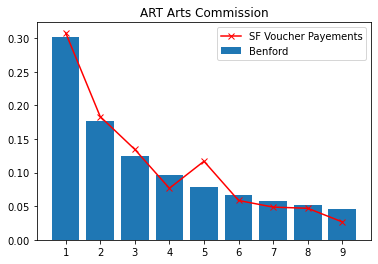

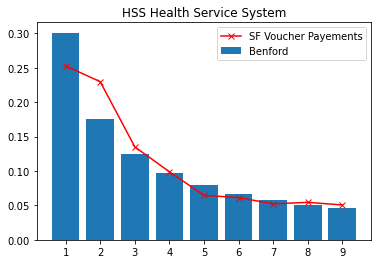

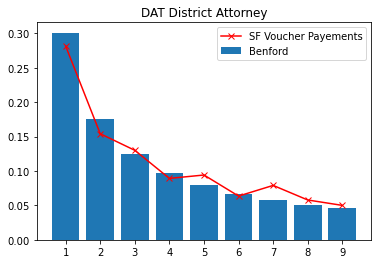

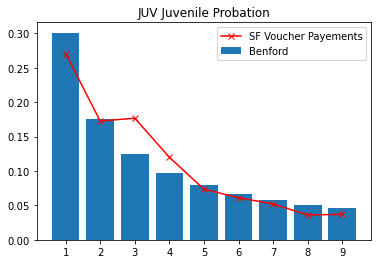

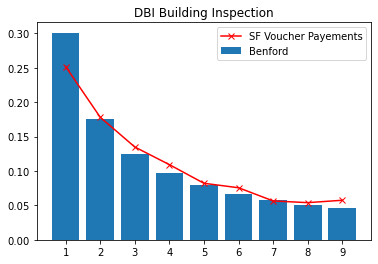

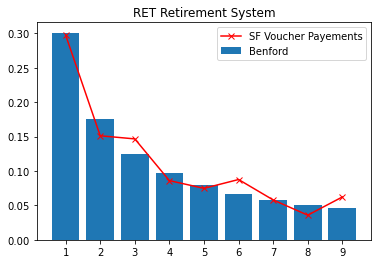

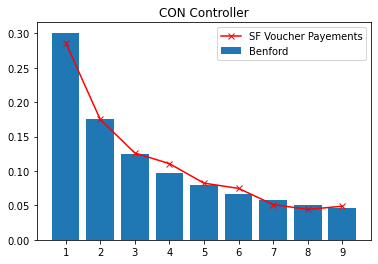

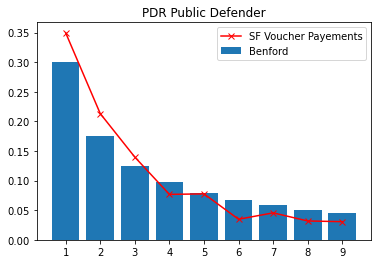

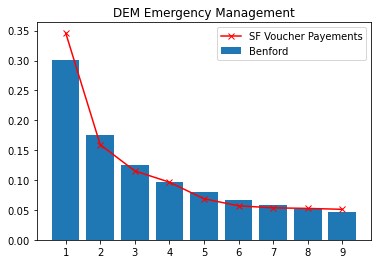

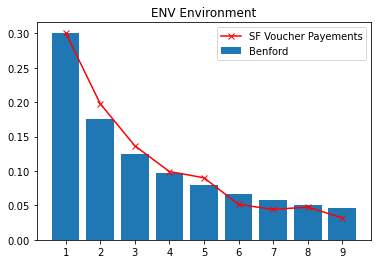

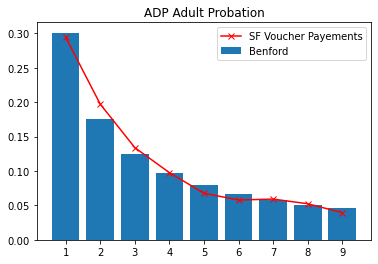

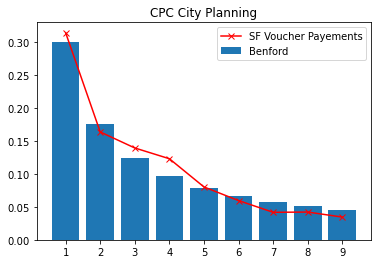

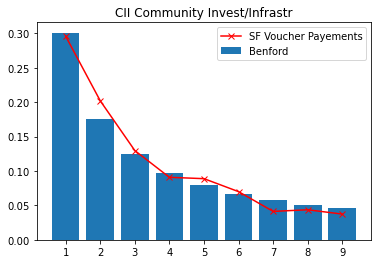

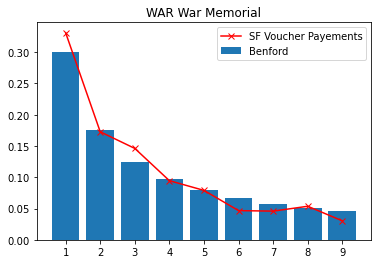

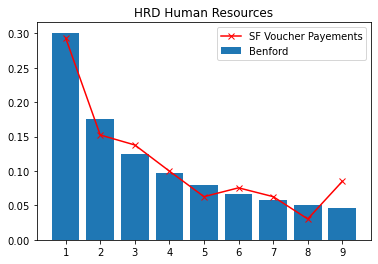

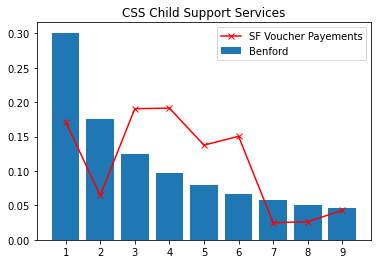

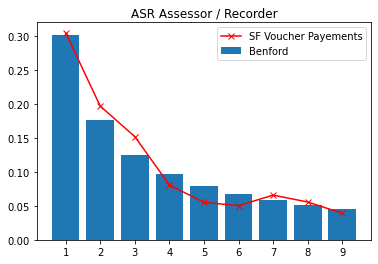

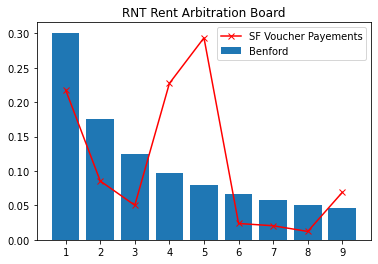

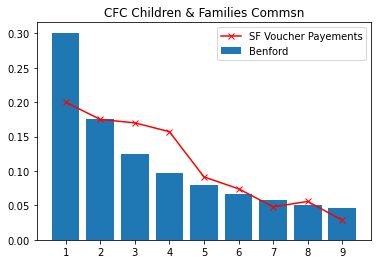

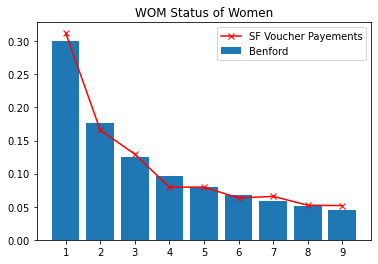

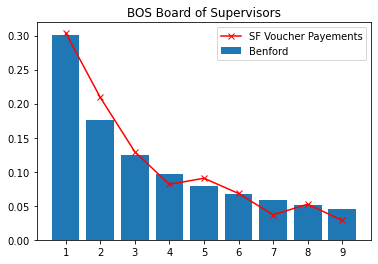

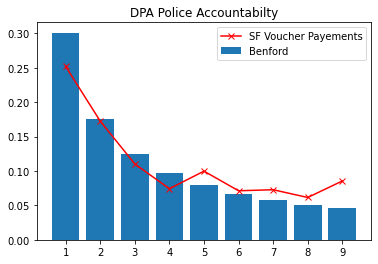

In [17]:
for dept in large_dept:
# All of the vouchers assigned by department

    dept_percentages = df.loc[df['Department'] == dept, 'first_digit'].value_counts(normalize=True).sort_index()

    plt.figure()
    plt.bar(digits, benford, label = 'Benford')
    plt.plot(digits, dept_percentages, color='r', marker='x', label = 'SF Voucher Payements')
    plt.title(dept)
    plt.xticks(digits)
    plt.legend()
    ;

## Deep Dive - Police

A handful of departments do no adhere to Benford's Law. This is an indication of human intervention. These departpartments include RNT Rent Arbitration Board, CSS Child Support Services, POL Police, and GEN General City / Unallocated.

In a deeper analsis of the Police department I evaluated all voucher payments that began with a "7". Of the almost 3,000 voucher payments, 93% of them were for non-personnel services primarily provided by two companies: GALLS LLC QUARTERMASTER LLC (39%) and ENTERPRISE RENT-A-CAR COMPANY OF SF LLC (32%). 

The line item detail for GALLS showed that the Police department purchased uniforms for what appeared to be a mostly standard price. About 82% of the GALLS voucher payments were for \\$715.12 and \\$720.84. The remaining 18% of the voucher payments were in the \\$700 and \\$70 range. It makes sense that a police department would need to purchase uniforms and the $700 price tag is reasonable considering the special clothing and gear police officers need, such as vests, boots and utility belt. I'm curious if the SF Police department had an initiative to buy new uniforms for its officers or hired a lot of new officers the past 2 years. 

The second biggest supplier was ENTERPRISE. The line item detail showed that over 95% of the voucher payments were for car rentals between \\$774 and \\$780. Further research is needed to understand why the Police department rents cars but it does not seem unreasonable that they would need to rent vehicles for normal operations. The consistency in price suggests there is a contract with ENTERPRISE or possibly a monthly rental agreement.  




In [18]:
# Searching by the Police department
dept = 'POL Police'
digit = 7
# Filter all checks by dept, by that amount

police = df[(df['Department'] == dept) & (df['first_digit'] == digit)]

In [19]:
print('The number of voucher payments starting with a "7": ' , police.shape[0])

The number of voucher payments starting with a "7":  2948


In [20]:
# What are the biggest purchase categories?
police.Character.value_counts(normalize=True)

Non-Personnel Services            0.929104
Materials & Supplies              0.045115
Charges for Services              0.010516
Capital Outlay                    0.009837
Current Assets                    0.002714
City Grant Program                0.001357
Mandatory Fringe Benefits         0.001018
Not Reported Liability Account    0.000339
Name: Character, dtype: float64

In [21]:
# Who are the biggest suppliers for the biggest category?
nps = police[police.Character == 'Non-Personnel Services']
nps.Vendor.value_counts(normalize=True).head(5)

GALLS LLC QUARTERMASTER LLC                0.391384
ENTERPRISE RENT-A-CAR COMPANY OF SF LLC    0.317999
GRM INFORMATION MANAGEMENT SERVICES        0.032494
STAPLES BUSINESS ADVANTAGE                 0.023731
FERRELLGAS LP                              0.014969
Name: Vendor, dtype: float64

### GALLS LLC QUARTERMASTER LLC

In [22]:
# Isolating the biggest vendor
galls = police[police.Vendor == 'GALLS LLC QUARTERMASTER LLC']
galls.shape

(1085, 27)

In [23]:
# What are the most common payment values?
galls['Vouchers Paid'].value_counts()
galls['Vouchers Paid'].value_counts(normalize=True).head(5)

715.12    0.520737
720.84    0.305069
763.60    0.033180
735.98    0.031336
751.23    0.011060
Name: Vouchers Paid, dtype: float64

In [24]:
# Example of a $715.12 purchase
uni1 = galls[galls['Vouchers Paid'] == 715.12]
uni1.head(2)

,Fiscal Year,Related Govt Units,Organization Group Code,Organization Group,Department Code,Department,Program Code,Program,Character Code,Character,Object Code,Object,Sub-object Code,Sub-object,Fund Type Code,Fund Type,Fund Code,Fund,Fund Category Code,Fund Category,Purchase Order,Vendor,Vouchers Paid,Vouchers Pending,Vouchers Pending Retainage,Voucher,first_digit
4259174,2019,NO,1,Public Protection,POL,POL Police,OPR,Operating,MTL_SUPP,Materials & Supplies,SAFETY,Safety,545310,Uniforms,GEN_FUND,General Fund,GEN_FUND~10000,GF Annual Account Ctrl,1.0,Operating,000005765803,GALLS LLC QUARTERMASTER LLC,715.12,0.0,0.0,0068088001,7
4259175,2019,NO,1,Public Protection,POL,POL Police,OPR,Operating,MTL_SUPP,Materials & Supplies,SAFETY,Safety,545310,Uniforms,GEN_FUND,General Fund,GEN_FUND~10000,GF Annual Account Ctrl,1.0,Operating,000005765803,GALLS LLC QUARTERMASTER LLC,715.12,0.0,0.0,0070286201,7


In [25]:
# Example of a $720.84 purchase
uni2 = galls[galls['Vouchers Paid'] == 720.84]
uni2.head(2)

,Fiscal Year,Related Govt Units,Organization Group Code,Organization Group,Department Code,Department,Program Code,Program,Character Code,Character,Object Code,Object,Sub-object Code,Sub-object,Fund Type Code,Fund Type,Fund Code,Fund,Fund Category Code,Fund Category,Purchase Order,Vendor,Vouchers Paid,Vouchers Pending,Vouchers Pending Retainage,Voucher,first_digit
4611107,2019,NO,1,Public Protection,POL,POL Police,OPR,Operating,NON_PERS_SVCS,Non-Personnel Services,TAX_LIC_PERM,Taxes: Licenses/Permits,552115,Sales-Use Tax,GEN_FUND,General Fund,GEN_FUND~10000,GF Annual Account Ctrl,1.0,Operating,000028531301,GALLS LLC QUARTERMASTER LLC,720.84,0.0,0.0,0087505501,7
4611108,2019,NO,1,Public Protection,POL,POL Police,OPR,Operating,NON_PERS_SVCS,Non-Personnel Services,TAX_LIC_PERM,Taxes: Licenses/Permits,552115,Sales-Use Tax,GEN_FUND,General Fund,GEN_FUND~10000,GF Annual Account Ctrl,1.0,Operating,000028531301,GALLS LLC QUARTERMASTER LLC,720.84,0.0,0.0,0087506101,7


### ENTERPRISE RENT-A-CAR COMPANY OF SF LLC

In [26]:
# Isolating the second biggest vendor
car = police[police.Vendor == 'ENTERPRISE RENT-A-CAR COMPANY OF SF LLC']
car.shape

(872, 27)

In [27]:
# What are the most common payment values?
car['Vouchers Paid'].value_counts()
car['Vouchers Paid'].value_counts(normalize=True).head()

776.99    0.269495
777.04    0.184633
778.50    0.095183
777.32    0.069954
775.72    0.034404
Name: Vouchers Paid, dtype: float64

In [28]:
# Example of a car rental
rent = car[car['Vouchers Paid'] == 776.99]
rent.head(2)

,Fiscal Year,Related Govt Units,Organization Group Code,Organization Group,Department Code,Department,Program Code,Program,Character Code,Character,Object Code,Object,Sub-object Code,Sub-object,Fund Type Code,Fund Type,Fund Code,Fund,Fund Category Code,Fund Category,Purchase Order,Vendor,Vouchers Paid,Vouchers Pending,Vouchers Pending Retainage,Voucher,first_digit
4340057,2019,NO,1,Public Protection,POL,POL Police,OPR,Operating,NON_PERS_SVCS,Non-Personnel Services,TAX_LIC_PERM,Taxes: Licenses/Permits,552115,Sales-Use Tax,GEN_FUND,General Fund,GEN_FUND~10000,GF Annual Account Ctrl,1.0,Operating,000019718301,ENTERPRISE RENT-A-CAR COMPANY OF SF LLC,776.99,0.0,0.0,0057131601,7
4340060,2019,NO,1,Public Protection,POL,POL Police,OPR,Operating,NON_PERS_SVCS,Non-Personnel Services,TAX_LIC_PERM,Taxes: Licenses/Permits,552115,Sales-Use Tax,GEN_FUND,General Fund,GEN_FUND~10000,GF Annual Account Ctrl,1.0,Operating,000019718301,ENTERPRISE RENT-A-CAR COMPANY OF SF LLC,776.99,0.0,0.0,0057208101,7


In [29]:
# There's a narrow price band for car rentals
# 95% of the car rentals are between $774 and $780

price1 = car[car['Vouchers Paid'] > 774]

price2 = price1[price1['Vouchers Paid'] < 780]

price2.shape[0] / car.shape[0]

0.9541284403669725

## Conclusion

Benford's Law is fun to apply to datasets but also requires a lot of extra research to understand anamolies caused by human intervention. The SF Police Department purchases of officer uniforms and rental vehicles seem perfectly reasonable and do not signal frad. 